In [ ]:
!pip install -q kaggle --quiet

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d wardaddy24/marble-surface-anomaly-detection-2

 95% 35.0M/36.8M [00:00<00:00, 119MB/s]
100% 36.8M/36.8M [00:00<00:00, 110MB/s]


In [ ]:
!unzip marble-surface-anomaly.zip 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
import keras as ks
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#directories of the train and test set
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

(256, 256, 3)


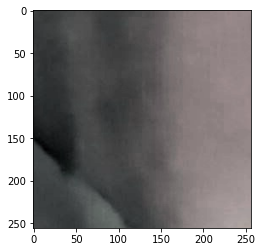

In [ ]:
def get_image(path):
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)
image = '/content/dataset/test/crack/_0_0_20210531_17292_0.jpg'
get_image(image)

# Image Data Generator

In [ ]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #validation_split=0.3,
                                   fill_mode='nearest',
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(48,48),
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')
    
    
    
    return train_generator
    

In [ ]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 2249 images belonging to 4 classes.
Found 688 images belonging to 4 classes.


In [ ]:
#labelnames
labelnames = traingen.class_indices
labelnames


{'crack': 0, 'dot': 1, 'good': 2, 'joint': 3}

In [ ]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [ ]:
valid = getdata(test_dir)

In [ ]:
valid.sample(5)

,image_abs_path,image_labels
39,/content/dataset/test/crack/_1280_512_20210531...,crack
441,/content/dataset/test/good/_256_3840_20210531_...,good
259,/content/dataset/test/dot/_1536_4352_20210531_...,dot
454,/content/dataset/test/good/_1280_1024_65.jpg,good
378,/content/dataset/test/good/_0_0_20210531_10552...,good


In [ ]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = int(n/2)
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

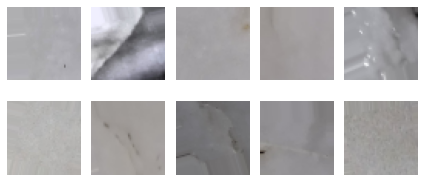

In [ ]:
visualize_gen(traingen)

In [ ]:
input_shape = traingen.image_shape
input_shape

(48, 48, 3)

# Build Model Architeture

In [ ]:
def imageclf2(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    model.add(ks.layers.Dropout(0.2))
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))

    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dropout(0.2))
    
    model.add(ks.layers.Dense(4,activation="softmax",
                              name="output"))
    model.summary()
    return model

model01 = imageclf2(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 8)         0         
                                                                 
 layer2 (Conv2D)             (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0

Epoch 1/100
113/113 [==============================] - 21s 171ms/step - loss: 1.2177 - accuracy: 0.3988 - val_loss: 1.1821 - val_accuracy: 0.3590
Epoch 2/100
113/113 [==============================] - 14s 122ms/step - loss: 1.1661 - accuracy: 0.4166 - val_loss: 1.1813 - val_accuracy: 0.3561
Epoch 3/100
113/113 [==============================] - 11s 101ms/step - loss: 1.1629 - accuracy: 0.4197 - val_loss: 1.1863 - val_accuracy: 0.3576
Epoch 4/100
113/113 [==============================] - 12s 106ms/step - loss: 1.1612 - accuracy: 0.4251 - val_loss: 1.1743 - val_accuracy: 0.3023
Epoch 5/100
113/113 [==============================] - 18s 158ms/step - loss: 1.1621 - accuracy: 0.4255 - val_loss: 1.1757 - val_accuracy: 0.3547
Epoch 6/100
113/113 [==============================] - 13s 112ms/step - loss: 1.1565 - accuracy: 0.4317 - val_loss: 1.1802 - val_accuracy: 0.3328
Epoch 7/100
113/113 [==============================] - 13s 111ms/step - loss: 1.1576 - accuracy: 0.4464 - val_loss: 1.1801 -

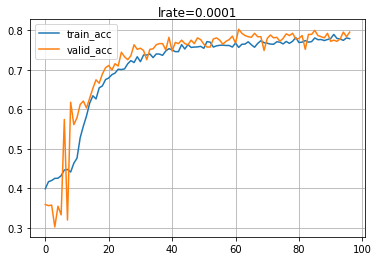

In [ ]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                         verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss="categorical_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        #steps_per_epoch = train_generator.n // bsize
                       )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history


model_com01 = compiler2(model01,traingen,validgen,100)

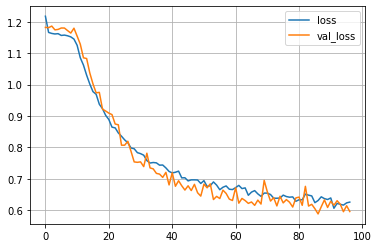

In [ ]:
#Visualise loss curves
history = model_com01[1]
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

35/35 [==============================] - 2s 65ms/step


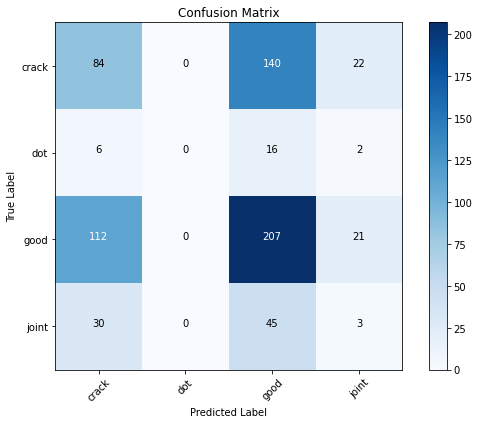

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# make predictions on the validation set
y_pred = model_com01[0].predict(validgen)

# get the predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# get the true class labels
y_true_classes = validgen.classes

# get the class names
class_names = list(validgen.class_indices.keys())

# plot a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the count of each class in the respective cells
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()


1/1 [==============================] - 0s 113ms/step


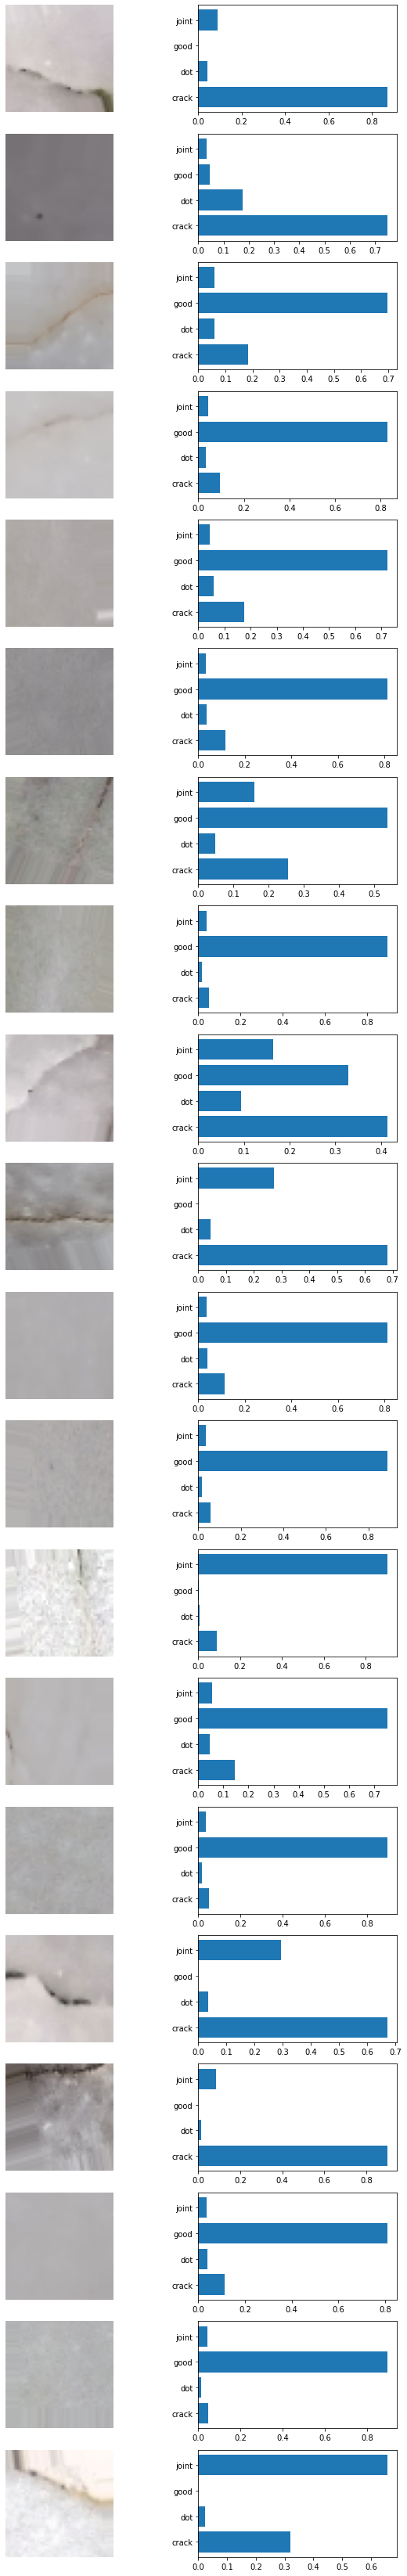

In [ ]:


# Define a function to display images and their predictions
def show_predictions(images, predictions, class_names):
    fig, axs = plt.subplots(len(images), 2, figsize=(10, 3*len(images)))
    for i in range(len(images)):
        axs[i, 0].imshow(images[i])
        axs[i, 0].axis('off')
        axs[i, 1].barh(np.arange(len(class_names)), predictions[i])
        axs[i, 1].set_yticks(np.arange(len(class_names)))
        axs[i, 1].set_yticklabels(class_names)
    plt.show()

# Get a batch of images and their labels from the validation set
images, labels = next(validgen)

# Make predictions on the batch of images using the trained model
predictions = model_com01[0].predict(images)

# Get the class names from the generator
class_names = list(validgen.class_indices.keys())

# Display the images and their predictions
show_predictions(images, predictions, class_names)
